In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/lpoint-competetion/Customer_Demographic_info.csv
/kaggle/input/lpoint-competetion/Product_Classify_info.csv
/kaggle/input/lpoint-competetion/Transaction_info.csv
/kaggle/input/lpoint-competetion/Online_Behavior_info.csv


In [2]:
df_trans = pd.read_csv("/kaggle/input/lpoint-competetion/Transaction_info.csv")
df_prodt = pd.read_csv("/kaggle/input/lpoint-competetion/Product_Classify_info.csv")

In [3]:
# Library
import pandas as np
from pandas import Series, DataFrame
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

te = TransactionEncoder()


# 소분류 Null Data 제거
df_prodt.drop([666])
df_prodt.drop([195])
df_prodt.drop([523])



df_trans['pd_c'] = df_trans['pd_c'].replace('unknown', np.nan)
df_trans['pd_c'] = df_trans['pd_c'].replace(667, np.nan)
df_trans['pd_c'] = df_trans['pd_c'].replace(196, np.nan)
df_trans['pd_c'] = df_trans['pd_c'].replace(524, np.nan)
df_trans = df_trans.dropna()
# unknown, NUll data 제거

df_trans['pd_c'] = df_trans['pd_c'].astype('int64') # merge하기 위해 데이터타입 변환
df_trans.sort_values(by=['clnt_id'], inplace=True)


PotenCust_ = DataFrame(df_trans.groupby(['clnt_id'])['biz_unit'].nunique() >= 2)
# biz_unit이 2개 이상이면 True 반환

PotenCust_.to_csv('PotenCust_.csv')
PotenCust = pd.read_csv('PotenCust_.csv') # Kaggle에서 DataFrame 형태로 만들기 위해

PotenCust['biz_unit'] = PotenCust['biz_unit'].astype('str')
PotenCust = PotenCust[PotenCust['biz_unit'].isin(['True'])]

'''
PotenCust : 우리 알고리즘에 맞는 고객을 정의하기 위해서 단일 Biz_unit에서
거래한 고객을 제외시킨 DataFrame

'''


# Dataset merge
trans_Poten = pd.merge(df_trans,PotenCust,on='clnt_id',how='right')

trans_Poten = trans_Poten[['clnt_id','biz_unit_x','pd_c']]
trans_Poten['pd_c'] = trans_Poten['pd_c'].astype('int64')
df_Poten = pd.merge(trans_Poten,df_prodt,on='pd_c',how='left')[['clnt_id','biz_unit_x','clac_nm3']]

df_Poten['biz_nm3'] = df_Poten['biz_unit_x'] +'_'+ df_Poten['clac_nm3']
# biz_unit, 소분류를 합쳐서 새로운 column 생성
Biz_nm3 = df_Poten[['clnt_id','biz_nm3']] 
Biz_nm3 = Biz_nm3.dropna()

In [4]:
lst =Biz_nm3.groupby(['clnt_id'])['biz_nm3'].apply(list) #Apriori를 위해 list형태로 변환
lst

clnt_id
2        [A03_Fried Tofu, A03_Crab Sticks, A03_Canned V...
9        [A03_Toothbrushes, A03_Frozen Hotdogs, A03_Oth...
20       [A03_Onions, A03_Eggplants, A03_Oyster Mushroo...
23       [B02_Onions, B02_Salads, B02_Soybean Sprouts, ...
24       [A03_Pasta Sauces, A03_Functional Milk, A03_Fr...
                               ...                        
72356    [A01_Other Functional Drinks, A01_Mobile Batte...
72373    [A02_Others, A03_Salads, A02_Electric Fans, A0...
72410    [A02_Kitchen Cookware Sets, B01_General Snacks...
72423            [B03_Beauty Supplements, A01_Cell Phones]
72424    [B01_Chicken Eggs, B01_Bakery, B01_Jellies, A0...
Name: biz_nm3, Length: 7190, dtype: object

In [5]:
te_ary = te.fit(lst).transform(lst)
apriori_te = pd.DataFrame(te_ary, columns=te.columns_)

In [6]:
frequent_itemsets = apriori(apriori_te, min_support=0.03, use_colnames=True)

In [7]:
'''
minsup 0.03의 Frequent Itemsets 생성
'''

#Arules
arules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.001)

arules["consequents_len"] = arules["consequents"].apply(lambda x: len(x))
arules["antecedents_len"] = arules["antecedents"].apply(lambda y: len(y))
result = arules[(arules["antecedents_len"] == 1) & (arules['consequents_len'] ==2)].sort_values(by=['lift'],ascending=True)
# antecedents 한 개, consequents 2개의 결과가 나오도록 Arules 실행

arules["consequents_len"] = arules["consequents"].apply(lambda x: len(x))
arules["antecedents_len"] = arules["antecedents"].apply(lambda y: len(y))
index_result = arules[(arules["antecedents_len"] == 1) & (arules['consequents_len'] ==2)].sort_values(by=['lift'],ascending=True)
'''
result dataframe에서 antecedents(1개), consequents(2개)이면서 세 거래가 모두 같은 곳에서 진행된 row는 지우고
비교하기 위해서 result, index_result 두 개의 데이터프레임을 만듦
'''

result["antecedents"] = result["antecedents"].apply(lambda x: list(x)[0:]).astype("unicode")
result["consequents"] = result["consequents"].apply(lambda y: list(y)[0:]).astype('unicode')
# Arulse의 결과가 frozenset으로 반환됨에 따라 unicode로 변환

result["antecedents"] = result["antecedents"].str.strip('[]')
result["consequents"] = result["consequents"].str.strip('[]')
# list '[]' 기호 제거

result["antecedents"] = result.antecedents.apply(lambda x: x.split(', '))
result["consequents"] = result.consequents.apply(lambda x: x.split("', "))
# consequents의 결과를 Biz_unit별로 구분하기 위해 split함

result["antecedents"]=result["antecedents"].apply(lambda x: [x[0][1:4]])
result["consequents"]=result["consequents"].apply(lambda y: [y[0][1:4],y[1][1:4]])
# Biz_unit만을 비교하기 위해서 Biz_unit만 남도록 문자열을 자름

result['antecedents_1'] = 0
result['consequents_1'] = 0
result['consequents_2'] = 0
result['T/F'] = 'different'
# 구분한 Biz_unit을 입력하기 위해 새로운 column 삽입


# Biz_unit을 구분하고 새로운 column에 삽입
for i in range(len(result['antecedents'])):
    a = str(result.iloc[i,0][0])
    b = str(result.iloc[i,1][0])
    c = str(result.iloc[i,1][1])
    
    result.iloc[i,11] = a
    result.iloc[i,12] = b
    result.iloc[i,13] = c
    i=i+1
    
    
# 모두 같은 Biz_unit의 경우 NaN삽입, 이후 dropna()
for i in range(len(result['antecedents'])):
    if result.iloc[i,11] == result.iloc[i,12] == result.iloc[i,13]:
        result.iloc[i,14] = np.nan
    i=i+1
      
result_ = result.dropna()

result_.sort_values(by=['lift'], ascending=False, inplace=True)


final = pd.merge(index_result, result_, left_index=True, right_index=True, how='right')
final[['antecedents_x','consequents_x','antecedent support_x',
       'consequent support_x','support_x','confidence_x',
       'lift_x','leverage_x','conviction_x','consequents_len_x',
       'antecedents_len_x']]

'''
Biz_unit구분을 위해 지웠던 상품 소분류명을 확인하기 위해서 처음 만들었던
index_result와 merge함
'''

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'\nBiz_unit구분을 위해 지웠던 상품 소분류명을 확인하기 위해서 처음 만들었던\nindex_result와 merge함\n'

# Visualization

## Library

In [8]:
import random
import matplotlib.pyplot as plt

In [9]:
final.head(5)

,antecedents_x,consequents_x,antecedent support_x,consequent support_x,support_x,confidence_x,lift_x,leverage_x,conviction_x,consequents_len_x,...,confidence_y,lift_y,leverage_y,conviction_y,consequents_len_y,antecedents_len_y,antecedents_1,consequents_1,consequents_2,T/F
14433,(A03_Corn Snacks),"(A03_General Snacks, B02_General Snacks)",0.142837,0.056885,0.032545,0.227848,4.005447,0.024420,1.221412,2,...,0.227848,4.005447,0.024420,1.221412,2,1,A03,A03,B02,different
14431,(A03_General Snacks),"(B02_General Snacks, A03_Corn Snacks)",0.185257,0.044228,0.032545,0.175676,3.972038,0.024352,1.159461,2,...,0.175676,3.972038,0.024352,1.159461,2,1,A03,B02,A03,different
16327,(B02_Fresh Milk),"(B02_Spoon Type Yogurts, A03_Fresh Milk)",0.200974,0.039917,0.030181,0.150173,3.762174,0.022159,1.129740,2,...,0.150173,3.762174,0.022159,1.129740,2,1,B02,B02,A03,different
12387,(B02_Soybean Sprouts),"(A03_Chicken Eggs, B02_Tofu)",0.104033,0.077191,0.030181,0.290107,3.758322,0.022150,1.299927,2,...,0.290107,3.758322,0.022150,1.299927,2,1,B02,A03,B02,different
16310,(B02_Fresh Milk),"(B02_Chicken Eggs, A03_Fresh Milk)",0.200974,0.045341,0.033658,0.167474,3.693676,0.024546,1.146702,2,...,0.167474,3.693676,0.024546,1.146702,2,1,B02,B02,A03,different


In [10]:
support=final.as_matrix(columns=['support_x'])
confidence=final.as_matrix(columns=['confidence_x'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [11]:
###  node Graph Function

def draw_graph(rules, rules_to_show):
    import networkx as nx  
    G1 = nx.DiGraph()
   
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
    for i in range (rules_to_show):
        G1.add_nodes_from(["R"+str(i)])
        for a in final.iloc[i]['antecedents_x']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 1)
        for c in final.iloc[i]['consequents_x']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight = 1)
 
    for node in G1:
        found_a_string = False
        for item in strs:
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')       
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=3, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()

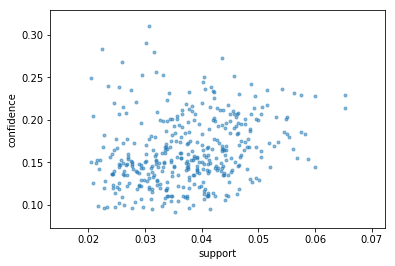

In [12]:
for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)

plt.scatter(support, confidence,   alpha=0.5, marker=".")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

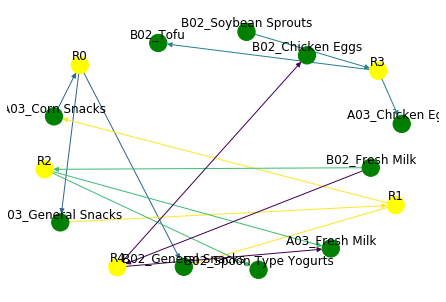

In [13]:
draw_graph(final, 5)